## Plot n chosen segment vs edit quality metric

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir
from utils.model_utils import prepare_device, quick_predict
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import histogram, bar_graph
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

In [3]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')

config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'

class_name = 'airplane'
n_select = 100
timestamp = '0127_103716'
paths_timestamp = '0126_161209'


In [4]:
# Load config file, models, and dataloader
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

config_json = read_json(config_path)
K = config_json['editor']['K']

device, device_ids = prepare_device(config_json['n_gpu'])

root_dir = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', '{}_{}', timestamp)
root_dir = root_dir.format(class_name, n_select)
save_paths_dir = os.path.join('paths', 'edits', 'semantics', '{}_{}'.format(class_name, n_select), paths_timestamp)

graph_save_dir = os.path.join(root_dir, 'graphs')

trial_paths_path = os.path.join(root_dir, 'trial_paths.txt')
csv_path = os.path.join(root_dir, 'results_table.csv')
val_paths_path = os.path.join(save_paths_dir, 'value_images_softmax.txt')

show = False


In [5]:
# Load objects
df = load_and_preprocess_csv(
    csv_path=csv_path,
    drop_duplicates=['ID'])

trial_paths = read_lists(trial_paths_path)
val_paths = read_lists(val_paths_path)

print("Restoring trial_paths from {}".format(trial_paths_path))
print("Restoring results csv from {}".format(csv_path))
print("Restoring segmentatation paths from {}".format(val_paths_path))

Restoring trial_paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/trial_paths.txt
Restoring results csv from saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/results_table.csv
Restoring segmentatation paths from paths/edits/semantics/airplane_100/0126_161209/value_images_softmax.txt


In [6]:
def match_idx(element, test_elements):
    n_repeat = test_elements.shape[0]
    chosen_idx = -1
    
    for n in range(n_repeat):
        if np.array_equal(element, test_elements[n]):
            chosen_idx = n
            break
    return chosen_idx
    
def get_segment_number(segmentation_paths):
    '''
    Given list of paths to saved segmentation dictionaries (output of segment_semantically.ipynb),
    Return list of numbers showing segment number chosen
    
    Arg(s):
        segmentation_paths : list[str]
            list of paths to segmentation objects
    
    Returns:
        chosen_idxs : list[int]
            list of indices of chosen segments
    '''
    chosen_idxs = []
    
    for segmentation_path in tqdm(segmentation_paths):
        # Load segmentation dictionary -> selected image and all cumulative images
        segmentation_dict = torch.load(segmentation_path)
        chosen_image = segmentation_dict['softmax_most_change_image']
        cumulative_images = segmentation_dict['softmax_cum_modifications']
        if torch.is_tensor(cumulative_images):
            cumulative_images = cumulative_images.cpu().numpy()
            
        # Find index that selected image matches cumulative images
        chosen_idxs.append(match_idx(chosen_image, cumulative_images))

    return chosen_idxs


In [7]:
segmentation_paths = [os.path.join(os.path.dirname(val_path), 'cumulative_segment_results.pth') for val_path in val_paths]

segment_idxs = get_segment_number(segmentation_paths)
    


100%|█████████████████████████████████████████████████████████████████████| 158/158 [00:02<00:00, 78.14it/s]


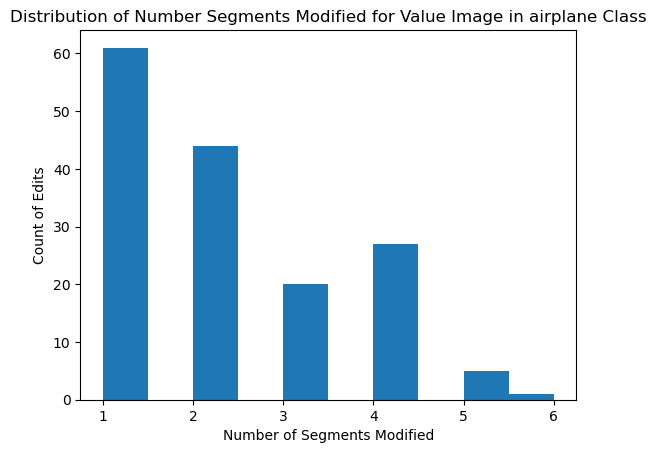

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 0 61 44 20 27  5  1]]


<Figure size 640x480 with 0 Axes>

In [8]:
histogram(
    data=segment_idxs,
    title='Distribution of Number Segments Modified for Value Image in {} Class'.format(class_name),
    xlabel='Number of Segments Modified',
    ylabel='Count of Edits')

bins = np.expand_dims(np.bincount(segment_idxs), axis=0)
# bins = np.stack([np.bincount(segment_idxs), np.bincount(segment_idxs)], axis=0)
bin_labels = [i for i in range(bins.shape[-1])]
bar_graph_save_path = os.path.join(graph_save_dir, 'summary', 'n_segment_bar_graph.png')
bar_graph(
    data=bins,
    xlabel='Number of Segments Modified',
    ylabel='Counts of Edits',
    title='Distribution of Number Segments Modified for Value Image in {} Class'.format(class_name),
    labels=bin_labels,
    xlabel_rotation=0,
    save_path=bar_graph_save_path,
    show=False)
    